In [1]:
import tensorflow as tf
import torch
import tf_keras_vis
from matplotlib import pyplot as plt
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow import keras

# Check does your computer support using GPU
print("GPU_available={}".format(torch.cuda.is_available()))
torch.device('cuda')

GPU_available=True


device(type='cuda')

In [2]:
arch_name = "Arch6"
model = keras.models.load_model('data/'+arch_name+'/CNN.h5')
model.summary()

c:\Users\Abdulsatar\.conda\envs\Image_Reconstruction\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: onnx2keras.activation_layers is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input.1 (InputLayer)        [(None, 1, 22, 500)]      0         
                                                                 
 LAYER_0_pad (ZeroPadding2D)  (None, 1, 24, 502)       0         
                                                                 
 LAYER_0 (Conv2D)            (None, 100, 22, 500)      1000      
                                                                 
 LAYER_1 (Activation)        (None, 100, 22, 500)      0         
                                                                 
 LAYER_2 (MaxPooling2D)      (None, 100, 11, 250)      0         
                                                                 
 LAYER_3_pad (ZeroPadding2D)  (None, 100, 13, 252)     0         
                                                                 
 LAYER_3 (Conv2D)            (None, 100, 11, 250)      90100 

In [3]:
layer_name = 'LAYER_18'
layer = model.get_layer(layer_name)
print(layer.activation)
#print(layer.filters)

<function linear at 0x0000023E6DF3F430>


In [4]:
# This instance constructs new model whose output is replaced to `block5_conv3` layer's output.
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)

# This instance modify the model's last activation function to linear one.
replace2linear = ReplaceToLinear()

# Because change the target you want to visualize, you MUST create 'Score' instance. 
# Here, our socre function returns the values corresponding to 63rd, 132nd and 320th filters of the layer.
model_classes = [0,1] # 0 => Sick Class; 1 => Normal Class
activations = []

for class_id in model_classes:

    print("Calculating for Class ", class_id)
    scores = CategoricalScore([class_id])
    activation_maximization = ActivationMaximization(
        model,
        model_modifier=[extract_intermediate_layer, replace2linear], # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
        clone=False
    )

    # Generate maximized activation
    result = activation_maximization(
        score=scores,
        callbacks=[Progress()],
        steps=400
    )

    activations.append(result)

Calculating for Class  0
400/400 [==============================] - 15s 31ms/step - Score: -0.0132 - TotalVariation2D: 3.5578 - Norm: 4.5092
Calculating for Class  1
400/400 [==============================] - 12s 30ms/step - Score: -3.7065e-04 - TotalVariation2D: 3.5683 - Norm: 4.4065


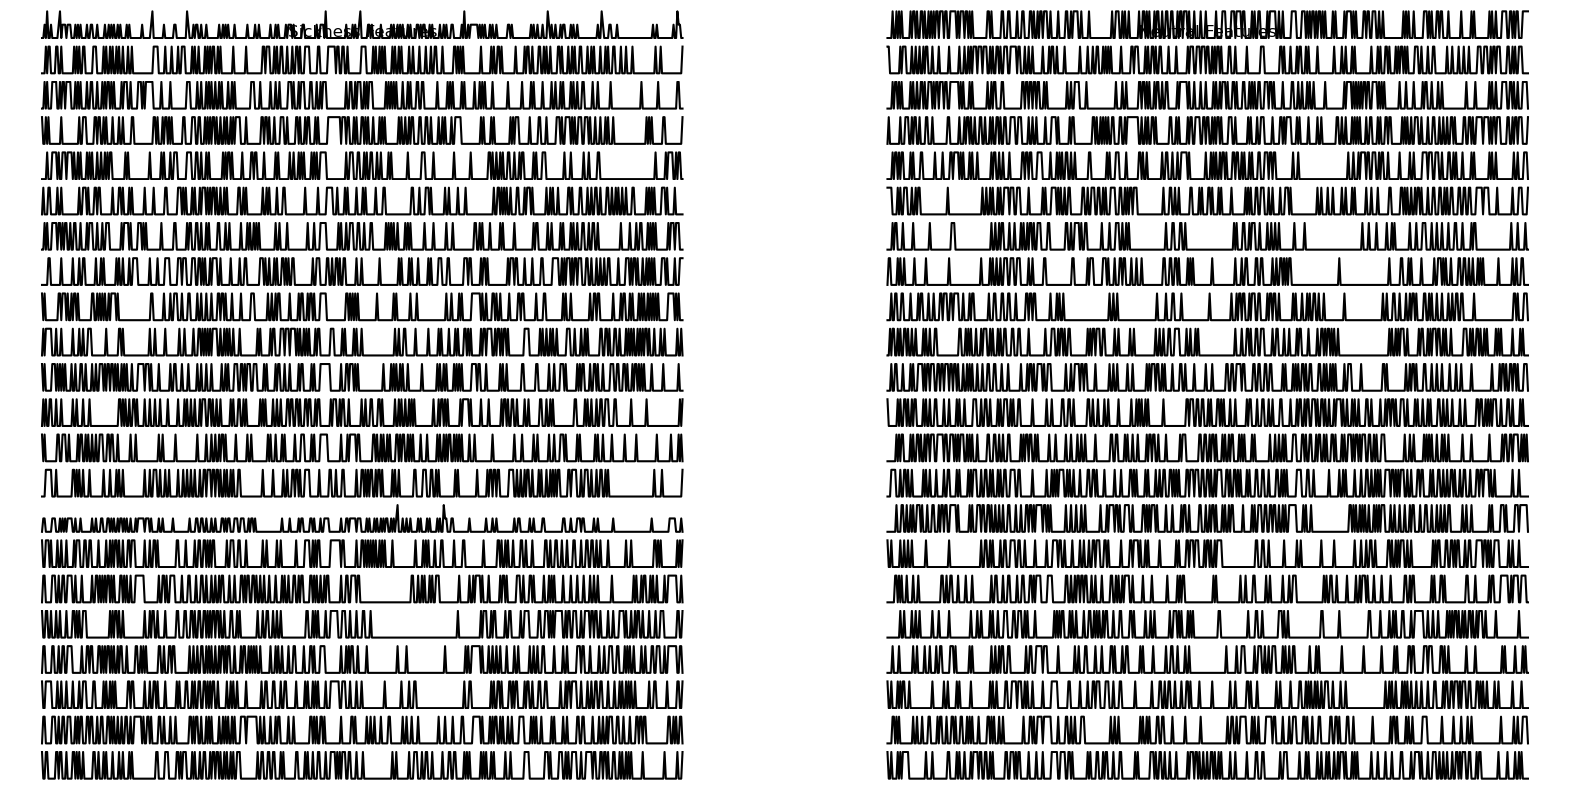

In [5]:

num_chan = 22
fig,inner = plt.subplots(num_chan,2, figsize=(20,10))
for idx, activation in enumerate(activations):
    data = activation[0][0]
    #fig,inner = plt.subplots(num_chan,1)
    title = "Neutral Features" if idx == 1 else "Sickness Features"
    for j in range(num_chan):
        ax = inner[j][idx]

        if j == 1:
            ax.set_title(title)
        
        ax.plot(range(500),data[j,:],'k')
        ax.axis('off')
        ax.set_xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        fig.add_subplot(ax)
plt.show()
fig.savefig("./Results/Plots/"+arch_name+"/"+layer_name+".jpg")

